In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution() 
import IPython.display as display
from PIL import Image
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import os
import seaborn as sns
from skimage import transform

keras = tf.keras


/home/staffa/agent/gpalmer/tensorflow/local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
tf.__version__

'2.1.0'

In [4]:
def getFileList(data_dir):
    data_dir = pathlib.Path(data_dir)
    class_names = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"], dtype='<U10')
    num_files = len(list(data_dir.glob('*/*.jpg')))
    if num_files == 0:
        num_files = len(list(data_dir.glob('*/*.png')))
    return tf.data.Dataset.list_files(str(data_dir/'*/*')), num_files, class_names

In [5]:
#list_ds, image_count, CLASS_NAMES = getFileList("./labelled_ads/")
list_ds, image_count, CLASS_NAMES = getFileList("./few_ads_aug/")
list_ds_test, test_image_count, TEST_CLASS_NAMES = getFileList("./eval_5000_pixels/")#getFileList("./ads_testing/")
list_ds_eval, eval_image_count, EVAL_CLASS_NAMES = getFileList("./ads_eval/")

In [6]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [7]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)#, result_type='RaggedTensor')
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES


In [8]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


In [9]:
def process_path(file_path):
  print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


In [10]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_eval = list_ds_eval.map(process_path, num_parallel_calls=AUTOTUNE)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


In [11]:
def prepare_for_training(ds, cache=False, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  #ds = ds.shuffle(buffer_size=shuffle_buffer_size)



  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [12]:
# train_size = int(0.7 * image_count)
# print(train_size)
# val_size = int(0.15 * image_count)
# print(val_size)
# test_size = int(0.15 * image_count)
# print(test_size)
#labeled_ds = labeled_ds.shuffle(buffer_size=image_count)
#train_dataset = labeled_ds.take(train_size)
#test_dataset = labeled_ds.skip(train_size)

# test_dataset = labeled_ds.take(test_size)#.cache()
# print("Take done")
# train_dataset = labeled_ds.skip(test_size).take(train_size)#.cache()
# print("Skip done")

#val_dataset = test_dataset.skip(test_size)
#test_dataset = test_dataset.take(test_size)

#train_ds = prepare_for_training(labeled_ds)
# train_ds = prepare_for_training(train_dataset)
# print("Train DS Prepared")
# test_ds = prepare_for_training(test_dataset)
# print("Test DS Prepared")
# #val_ds = prepare_for_training(val_dataset)

train_ds = prepare_for_training(labeled_ds)
test_ds = prepare_for_training(labeled_ds_test)
eval_ds = prepare_for_training(labeled_ds_eval)

image_batch, label_batch = next(iter(train_ds))
print("iter done")

iter done


# MobileNet V2

In [13]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 1280)


In [15]:
base_model.trainable = False


In [16]:
# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [18]:
prediction_layer = keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 4)


In [19]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [21]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
# BATCH_SIZE = 32
# SHUFFLE_BUFFER_SIZE = 1000

# train_batches = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# validation_batches = train_ds.batch(BATCH_SIZE)
# test_batches = train_ds.batch(BATCH_SIZE)





In [23]:
initial_epochs = 20
validation_steps=20

# loss0,accuracy0 = model.evaluate(test_ds, steps = validation_steps)


In [24]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=test_ds,
                    steps_per_epoch=100,
                    validation_steps=validation_steps)


Train for 100 steps, validate for 20 steps
Epoch 1/20
100/100 [==============================] - 13s 135ms/step - loss: 0.6172 - accuracy: 0.7292 - val_loss: 0.6162 - val_accuracy: 0.7387
Epoch 2/20
100/100 [==============================] - 6s 62ms/step - loss: 0.5372 - accuracy: 0.7534 - val_loss: 0.5735 - val_accuracy: 0.7480
Epoch 3/20
100/100 [==============================] - 6s 60ms/step - loss: 0.4849 - accuracy: 0.7671 - val_loss: 0.5658 - val_accuracy: 0.7520
Epoch 4/20
100/100 [==============================] - 6s 57ms/step - loss: 0.4559 - accuracy: 0.7771 - val_loss: 0.5460 - val_accuracy: 0.7508
Epoch 5/20
100/100 [==============================] - 6s 56ms/step - loss: 0.4321 - accuracy: 0.7884 - val_loss: 0.5766 - val_accuracy: 0.7504
Epoch 6/20
100/100 [==============================] - 6s 58ms/step - loss: 0.4076 - accuracy: 0.8027 - val_loss: 0.5826 - val_accuracy: 0.7527
Epoch 7/20
100/100 [==============================] - 6s 59ms/step - loss: 0.3889 - accuracy: 0.8

In [25]:
# def load(filename):
#     np_image = Image.open(filename)
#     np_image = np.array(np_image).astype('float32')/255
#     np_image = transform.resize(np_image, (224, 224, 3))
#     np_image = np.expand_dims(np_image, axis=0)
#     return np_image

# path = '1887_label2.jpg'
# model.predict_classes([load(path)])

### Save Model

In [26]:
model.save('models/26_03_2020.h5')
#model.load('models/test.h5')

In [27]:
# tf.math.confusion_matrix(
#     labels,
#     predictions,
#     num_classes=None,
#     weights=None,
#     dtype=tf.dtypes.int32,
#     name=None
# )

labels = []
predictions = []
iterations = int(np.ceil(test_image_count/BATCH_SIZE))

for i in range(iterations):

    image_batch, label_batch = next(iter(test_ds))

    predictions = predictions + list(model.predict_classes([image_batch, label_batch]))
    labels = labels + list(np.argmax(label_batch, axis=1))

In [28]:
c = tf.math.confusion_matrix(labels, predictions)
#c = np.array(c) / np.array(c).astype(np.float).sum(axis=1)
c

#sns.heatmap(c, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
#plt.yticks(rotation=0) 
#plt.show()

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[  18,   85,   74,   15],
       [ 185, 1710, 1112,  976],
       [  15,   19,   21,    3],
       [  15,   16,   15,    9]], dtype=int32)>

In [29]:
tf.math.confusion_matrix(labels, predictions)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[  18,   85,   74,   15],
       [ 185, 1710, 1112,  976],
       [  15,   19,   21,    3],
       [  15,   16,   15,    9]], dtype=int32)>

In [30]:
CLASS_NAMES

array([u'food', u'other', u'gambling', u'alc'], dtype='<U10')

In [31]:
TEST_CLASS_NAMES

array([u'food', u'other', u'gambling', u'alc'], dtype='<U10')

In [32]:
EVAL_CLASS_NAMES

array([u'food', u'other', u'gambling', u'alc'], dtype='<U10')

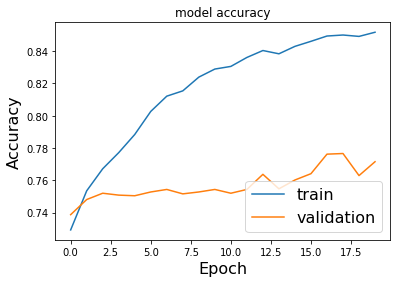

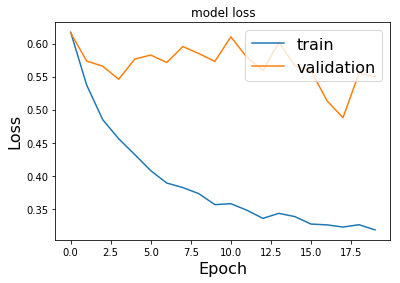

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['train', 'validation'], loc='lower right', fontsize=16)
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['train', 'validation'], loc='upper right', fontsize=16)
plt.show()

In [34]:
history.history.keys()

['loss', u'val_accuracy', 'val_loss', u'accuracy']

In [35]:
def img2array(data_path, desired_size=None, expand=False, view=False):
    """Loads an RGB image as a 3D or 4D numpy array."""
    img = Image.open(data_path)
    img = img.convert('RGB')
    if desired_size:
        img = img.resize((desired_size[1], desired_size[0]))
    if view:
        img.show()
    x = np.asarray(img, dtype='float32')
    if expand:
        x = np.expand_dims(x, axis=0)
    x /= 255.0
    return x


0 ./eval_5000_pixels/food/MULTISHOT_0414_001691_11masked.png


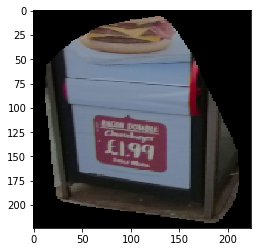

0 ./eval_5000_pixels/food/MULTISHOT_7130_001718_0masked.png


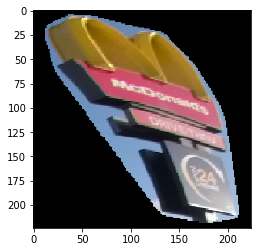

0 ./eval_5000_pixels/food/MULTISHOT_7130_001819_0masked.png


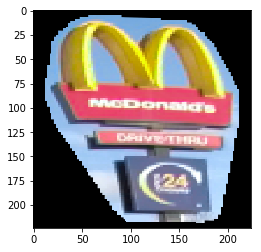

0 ./eval_5000_pixels/food/MULTISHOT_0414_001715_0masked.png


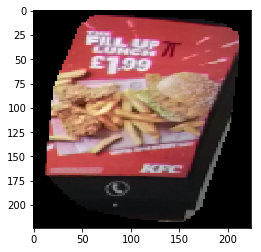

0 ./eval_5000_pixels/food/MULTISHOT_0084_003545_0masked.png


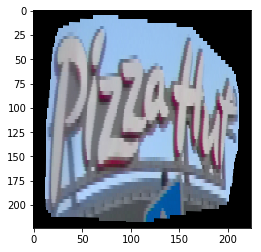

0 ./eval_5000_pixels/food/MULTISHOT_7130_001783_0masked.png


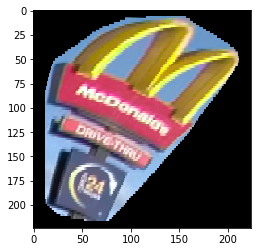

0 ./eval_5000_pixels/food/MULTISHOT_7130_001720_0masked.png


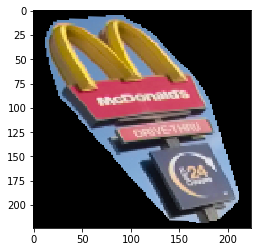

0 ./eval_5000_pixels/food/MULTISHOT_0084_000157_0masked.png


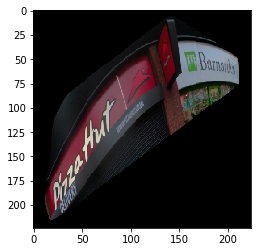

0 ./eval_5000_pixels/food/MULTISHOT_0414_001714_1masked.png


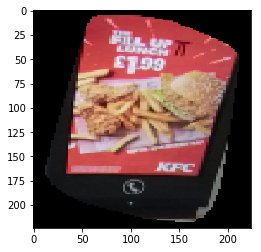

0 ./eval_5000_pixels/food/MULTISHOT_0414_001599_4masked.png


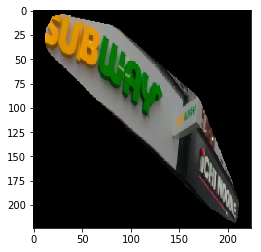

0 ./eval_5000_pixels/food/MULTISHOT_7130_001880_0masked.png


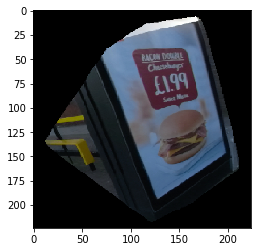

0 ./eval_5000_pixels/food/MULTISHOT_0414_004834_8masked.png


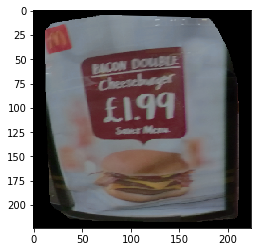

0 ./eval_5000_pixels/food/MULTISHOT_7130_001787_0masked.png


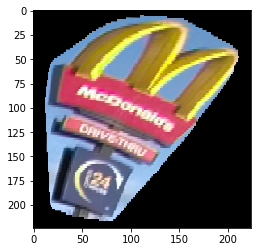

0 ./eval_5000_pixels/food/MULTISHOT_7130_001712_0masked.png


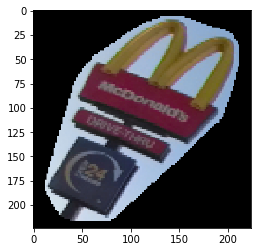

0 ./eval_5000_pixels/food/MULTISHOT_0414_004832_8masked.png


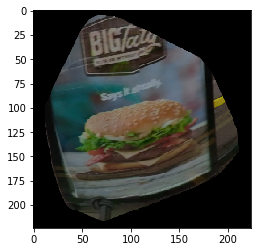

0 ./eval_5000_pixels/food/MULTISHOT_7130_001788_0masked.png


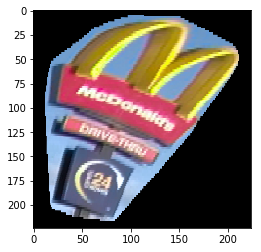

0 ./eval_5000_pixels/food/MULTISHOT_0414_001711_1masked.png


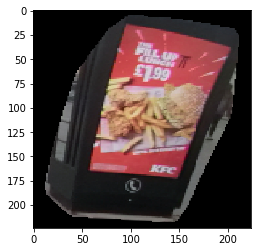

0 ./eval_5000_pixels/food/MULTISHOT_7130_004313_0masked.png


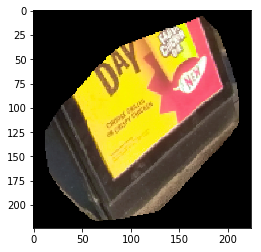

0 ./eval_5000_pixels/food/MULTISHOT_0084_000156_0masked.png


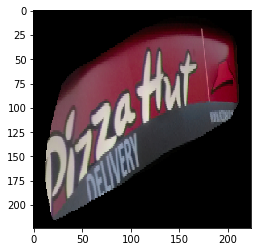

0 ./eval_5000_pixels/food/MULTISHOT_7130_001786_0masked.png


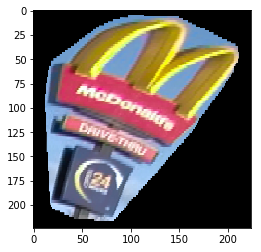

0 ./eval_5000_pixels/food/MULTISHOT_7130_001879_9masked.png


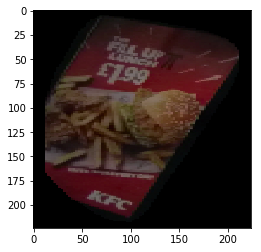

0 ./eval_5000_pixels/food/MULTISHOT_0084_000155_0masked.png


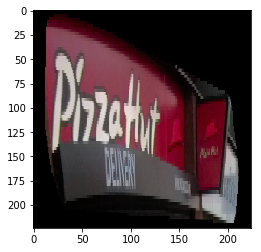

0 ./eval_5000_pixels/food/MULTISHOT_7130_001747_0masked.png


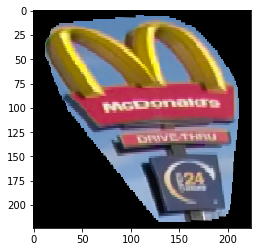

0 ./eval_5000_pixels/food/MULTISHOT_7130_001719_0masked.png


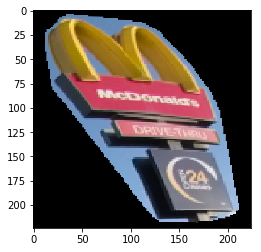

0 ./eval_5000_pixels/food/MULTISHOT_7130_001721_0masked.png


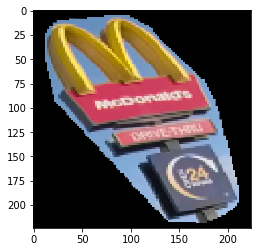

0 ./eval_5000_pixels/other/MULTISHOT_0084_005469_0masked.png


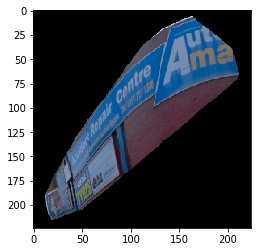

0 ./eval_5000_pixels/other/MULTISHOT_0084_000706_1masked.png


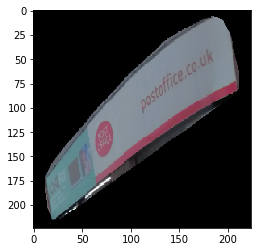

0 ./eval_5000_pixels/other/MULTISHOT_0084_001018_4masked.png


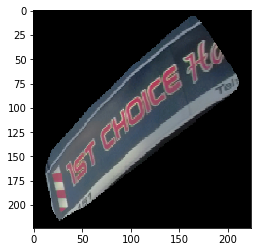

0 ./eval_5000_pixels/other/MULTISHOT_6925_000094_7masked.png


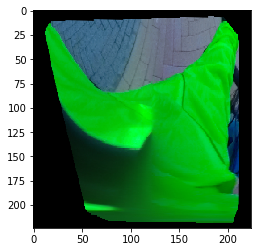

0 ./eval_5000_pixels/other/MULTISHOT_0414_000838_1masked.png


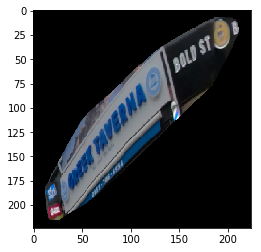

0 ./eval_5000_pixels/other/MULTISHOT_0414_004955_3masked.png


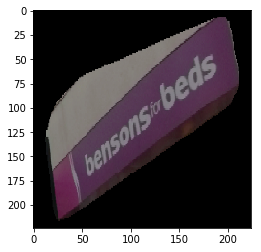

0 ./eval_5000_pixels/other/MULTISHOT_0414_000694_7masked.png


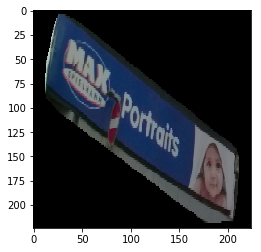

0 ./eval_5000_pixels/other/MULTISHOT_0084_000324_0masked.png


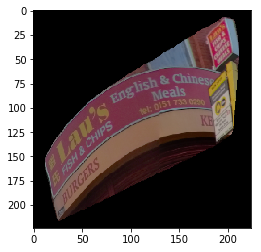

0 ./eval_5000_pixels/other/MULTISHOT_7130_002105_12masked.png


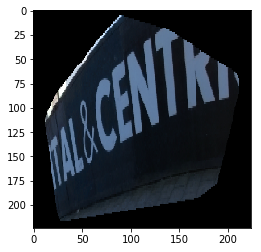

0 ./eval_5000_pixels/other/MULTISHOT_0084_000864_13masked.png


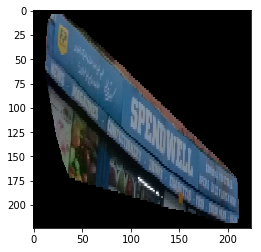

0 ./eval_5000_pixels/other/MULTISHOT_0414_001595_5masked.png


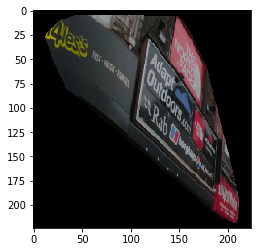

0 ./eval_5000_pixels/other/MULTISHOT_7130_003184_3masked.png


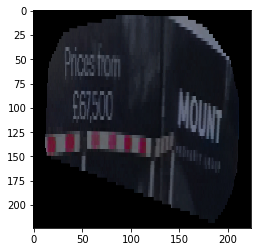

0 ./eval_5000_pixels/other/MULTISHOT_7130_003946_3masked.png


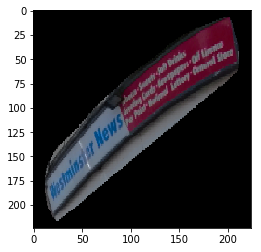

0 ./eval_5000_pixels/other/MULTISHOT_0414_001627_0masked.png


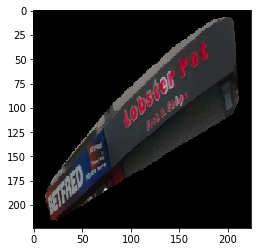

0 ./eval_5000_pixels/other/MULTISHOT_7130_006133_0masked.png


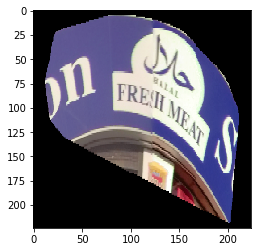

0 ./eval_5000_pixels/other/MULTISHOT_0084_006549_0masked.png


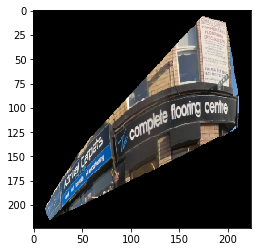

0 ./eval_5000_pixels/other/MULTISHOT_6925_000100_3masked.png


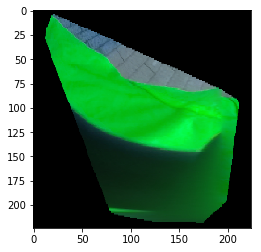

0 ./eval_5000_pixels/other/MULTISHOT_0084_000870_2masked.png


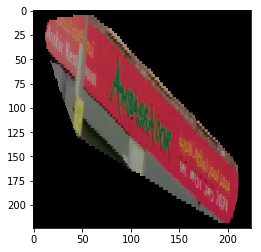

0 ./eval_5000_pixels/other/MULTISHOT_0414_004867_0masked.png


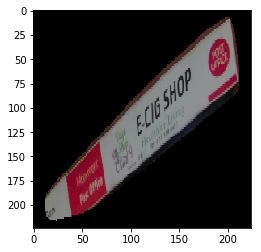

0 ./eval_5000_pixels/other/MULTISHOT_0084_001533_6masked.png


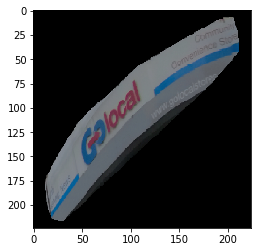

0 ./eval_5000_pixels/other/MULTISHOT_0414_000645_20masked.png


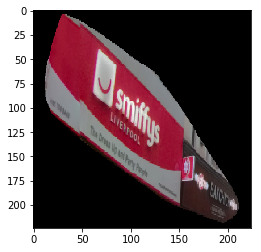

0 ./eval_5000_pixels/other/MULTISHOT_7130_003106_0masked.png


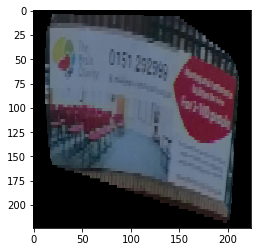

0 ./eval_5000_pixels/other/MULTISHOT_0414_004485_4masked.png


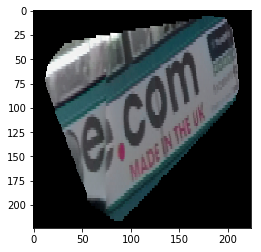

0 ./eval_5000_pixels/other/MULTISHOT_7130_004780_0masked.png


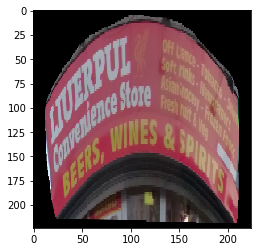

0 ./eval_5000_pixels/other/MULTISHOT_6925_000090_3masked.png


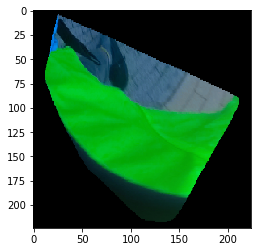

0 ./eval_5000_pixels/other/MULTISHOT_7130_006822_3masked.png


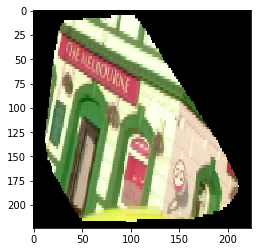

0 ./eval_5000_pixels/other/MULTISHOT_7130_005899_1masked.png


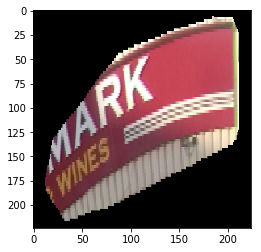

0 ./eval_5000_pixels/other/MULTISHOT_7130_008325_2masked.png


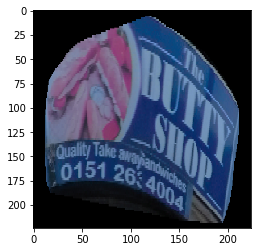

0 ./eval_5000_pixels/other/MULTISHOT_0084_001537_1masked.png


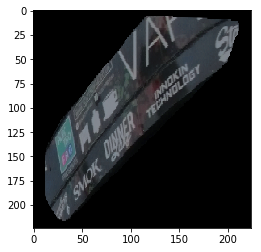

0 ./eval_5000_pixels/other/MULTISHOT_7130_008396_0masked.png


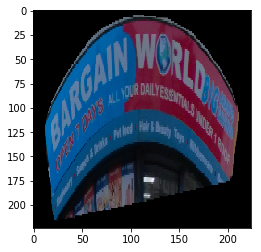

0 ./eval_5000_pixels/other/MULTISHOT_0084_000327_3masked.png


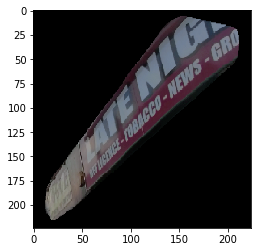

0 ./eval_5000_pixels/other/MULTISHOT_0414_000709_3masked.png


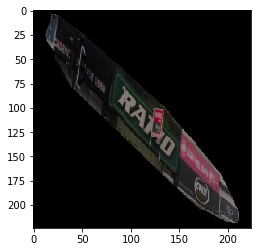

0 ./eval_5000_pixels/other/MULTISHOT_0084_001674_0masked.png


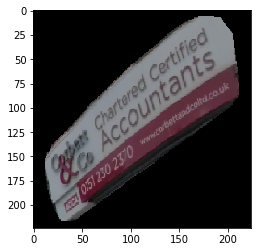

0 ./eval_5000_pixels/other/MULTISHOT_0414_000643_5masked.png


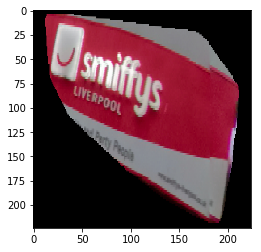

0 ./eval_5000_pixels/other/MULTISHOT_0084_000993_1masked.png


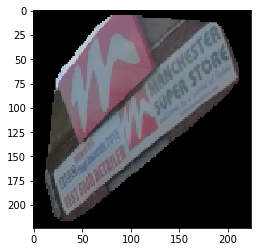

0 ./eval_5000_pixels/other/MULTISHOT_0414_001687_11masked.png


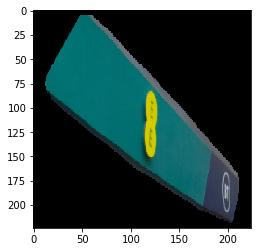

0 ./eval_5000_pixels/other/MULTISHOT_0414_000708_3masked.png


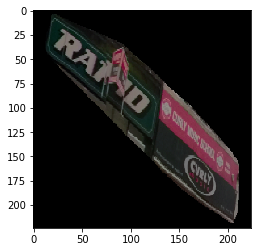

0 ./eval_5000_pixels/other/MULTISHOT_0084_001531_8masked.png


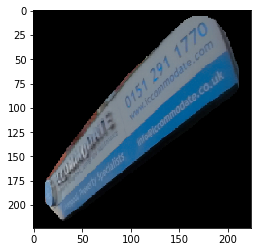

0 ./eval_5000_pixels/other/MULTISHOT_7130_004788_3masked.png


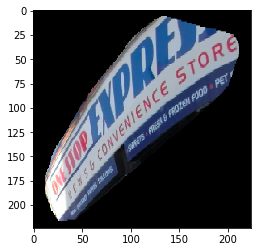

0 ./eval_5000_pixels/other/MULTISHOT_0084_000321_3masked.png


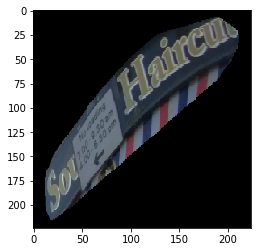

0 ./eval_5000_pixels/other/MULTISHOT_0414_000634_1masked.png


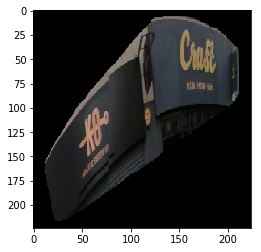

0 ./eval_5000_pixels/other/MULTISHOT_0084_001595_2masked.png


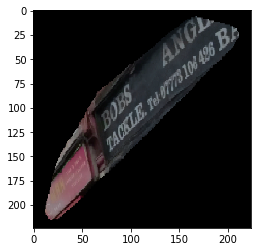

0 ./eval_5000_pixels/other/MULTISHOT_0084_000966_0masked.png


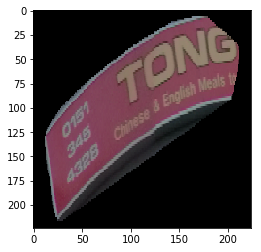

0 ./eval_5000_pixels/other/MULTISHOT_0084_005327_1masked.png


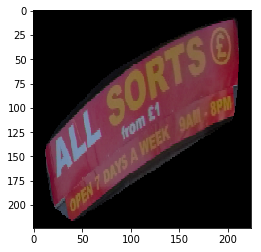

0 ./eval_5000_pixels/other/MULTISHOT_7130_007519_4masked.png


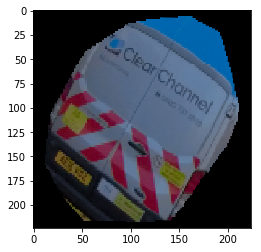

0 ./eval_5000_pixels/other/MULTISHOT_0084_000336_2masked.png


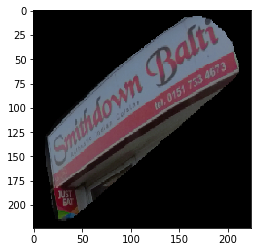

0 ./eval_5000_pixels/other/MULTISHOT_0414_004133_0masked.png


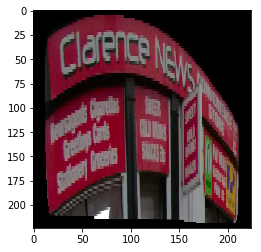

0 ./eval_5000_pixels/other/MULTISHOT_0414_000728_1masked.png


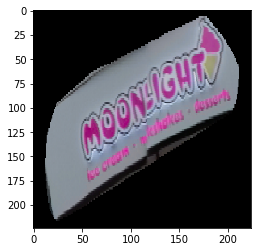

0 ./eval_5000_pixels/other/MULTISHOT_0084_005269_2masked.png


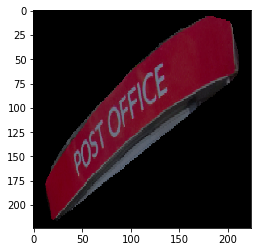

0 ./eval_5000_pixels/other/MULTISHOT_0084_005288_9masked.png


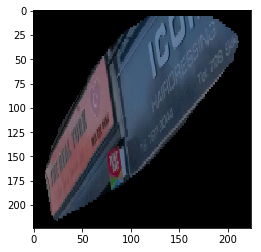

0 ./eval_5000_pixels/other/MULTISHOT_0084_000862_6masked.png


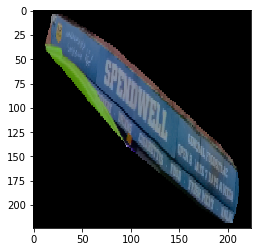

0 ./eval_5000_pixels/other/MULTISHOT_0084_005470_1masked.png


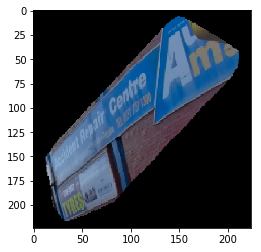

0 ./eval_5000_pixels/other/MULTISHOT_7130_004658_0masked.png


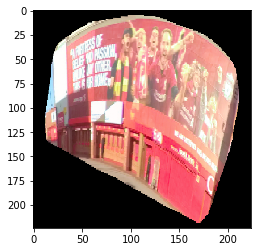

0 ./eval_5000_pixels/other/MULTISHOT_6925_000097_7masked.png


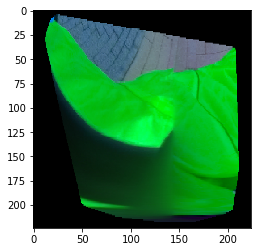

0 ./eval_5000_pixels/other/MULTISHOT_0084_000742_0masked.png


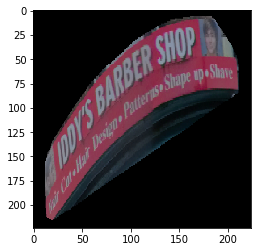

0 ./eval_5000_pixels/other/MULTISHOT_0084_000317_0masked.png


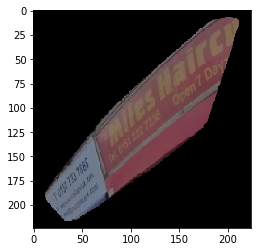

0 ./eval_5000_pixels/other/MULTISHOT_7130_004653_0masked.png


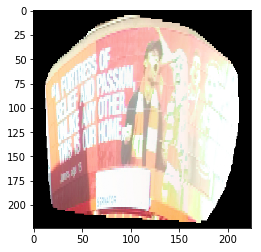

0 ./eval_5000_pixels/other/MULTISHOT_7130_006096_0masked.png


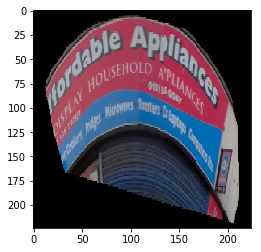

0 ./eval_5000_pixels/other/MULTISHOT_7130_004613_11masked.png


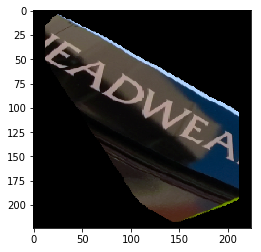

0 ./eval_5000_pixels/other/MULTISHOT_0414_001653_15masked.png


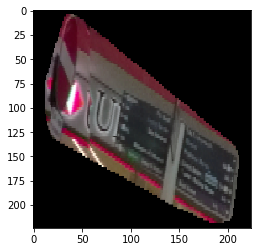

0 ./eval_5000_pixels/other/MULTISHOT_0084_005657_0masked.png


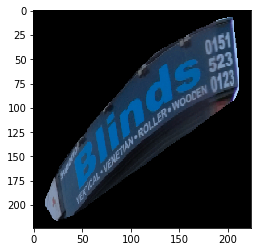

0 ./eval_5000_pixels/other/MULTISHOT_7130_008336_0masked.png


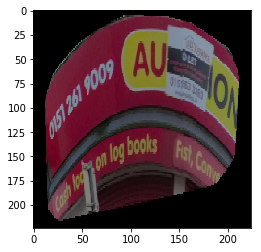

0 ./eval_5000_pixels/other/MULTISHOT_7130_006114_11masked.png


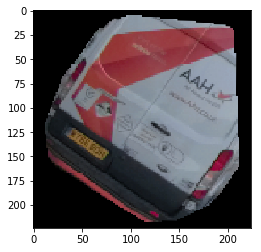

0 ./eval_5000_pixels/other/MULTISHOT_7130_004649_4masked.png


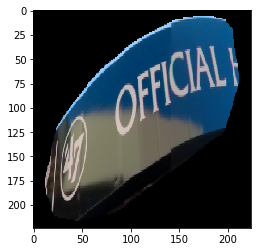

0 ./eval_5000_pixels/other/MULTISHOT_0084_000163_0masked.png


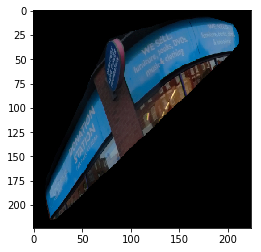

0 ./eval_5000_pixels/other/MULTISHOT_7130_006279_0masked.png


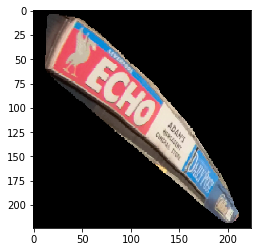

0 ./eval_5000_pixels/other/MULTISHOT_0414_000618_6masked.png


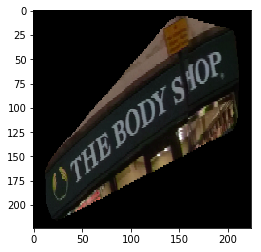

0 ./eval_5000_pixels/other/MULTISHOT_7130_008337_0masked.png


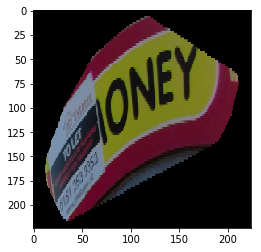

0 ./eval_5000_pixels/other/MULTISHOT_0084_000866_8masked.png


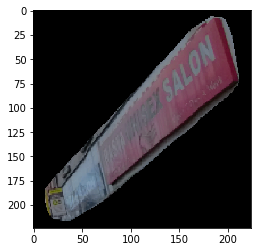

0 ./eval_5000_pixels/other/MULTISHOT_0414_004052_6masked.png


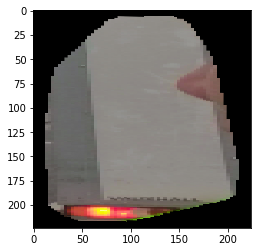

0 ./eval_5000_pixels/other/MULTISHOT_0084_001576_4masked.png


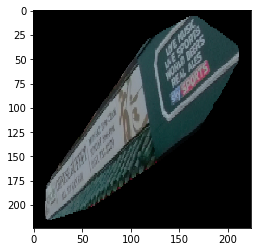

0 ./eval_5000_pixels/other/MULTISHOT_0414_001306_0masked.png


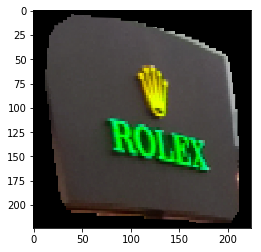

0 ./eval_5000_pixels/other/MULTISHOT_7130_003169_1masked.png


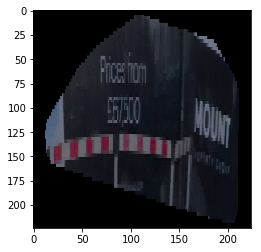

0 ./eval_5000_pixels/other/MULTISHOT_6925_000096_1masked.png


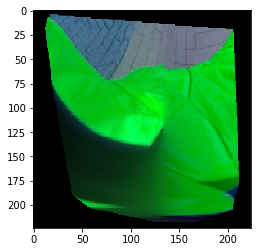

0 ./eval_5000_pixels/other/MULTISHOT_0414_001597_1masked.png


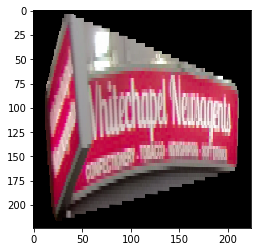

0 ./eval_5000_pixels/other/MULTISHOT_0414_001608_16masked.png


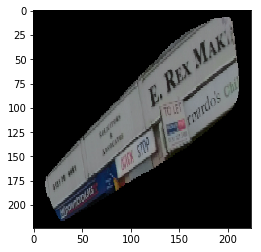

0 ./eval_5000_pixels/other/MULTISHOT_7130_006322_0masked.png


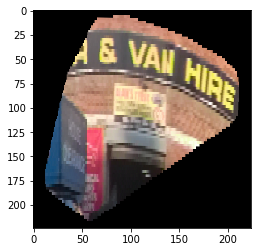

0 ./eval_5000_pixels/other/MULTISHOT_0414_000433_0masked.png


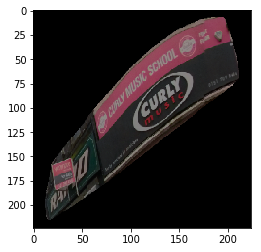

0 ./eval_5000_pixels/other/MULTISHOT_7130_000654_0masked.png


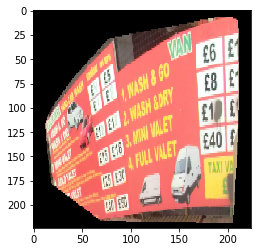

0 ./eval_5000_pixels/other/MULTISHOT_0414_001392_1masked.png


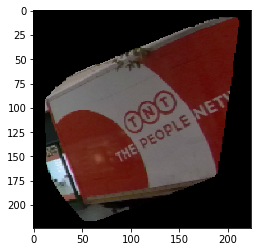

0 ./eval_5000_pixels/other/MULTISHOT_0414_000575_4masked.png


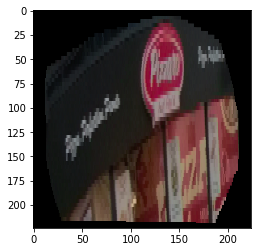

0 ./eval_5000_pixels/other/MULTISHOT_7130_004611_5masked.png


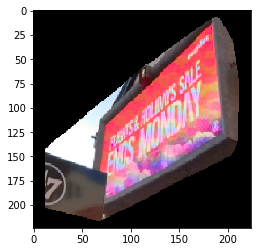

0 ./eval_5000_pixels/other/MULTISHOT_0084_000865_1masked.png


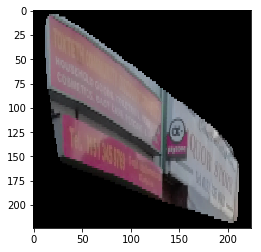

0 ./eval_5000_pixels/other/MULTISHOT_6925_000098_6masked.png


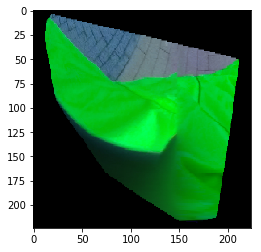

0 ./eval_5000_pixels/other/MULTISHOT_7130_004652_0masked.png


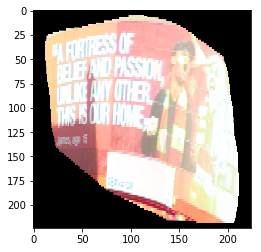

0 ./eval_5000_pixels/other/MULTISHOT_0414_004701_1masked.png


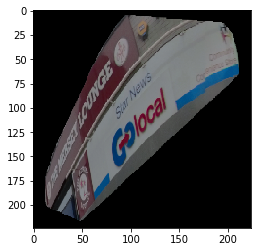

0 ./eval_5000_pixels/other/MULTISHOT_7130_004612_13masked.png


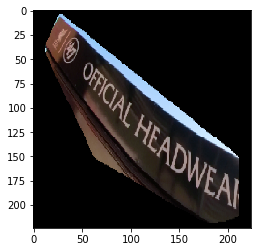

0 ./eval_5000_pixels/other/MULTISHOT_6925_000105_4masked.png


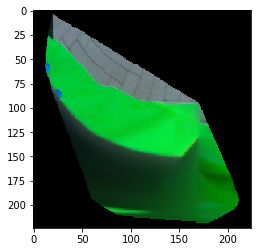

0 ./eval_5000_pixels/other/MULTISHOT_6925_000104_7masked.png


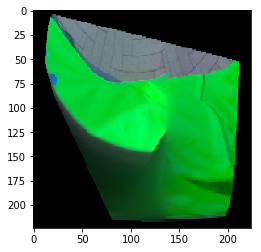

0 ./eval_5000_pixels/other/MULTISHOT_7130_004988_0masked.png


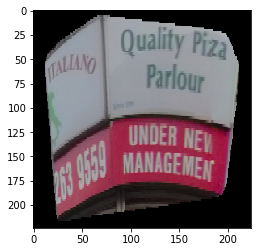

0 ./eval_5000_pixels/other/MULTISHOT_7130_004599_2masked.png


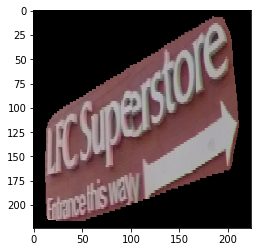

0 ./eval_5000_pixels/other/MULTISHOT_0084_000864_0masked.png


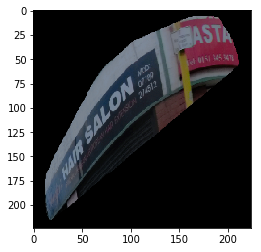

0 ./eval_5000_pixels/other/MULTISHOT_7130_001513_0masked.png


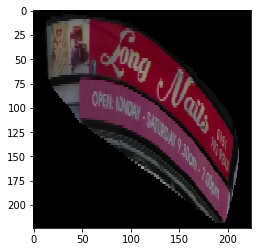

0 ./eval_5000_pixels/other/MULTISHOT_0414_000438_2masked.png


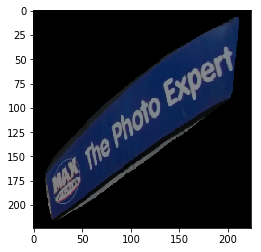

0 ./eval_5000_pixels/other/MULTISHOT_6925_000055_1masked.png


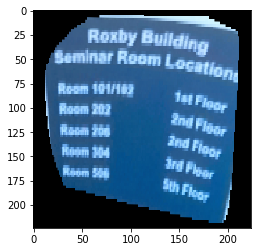

0 ./eval_5000_pixels/other/MULTISHOT_0084_000658_0masked.png


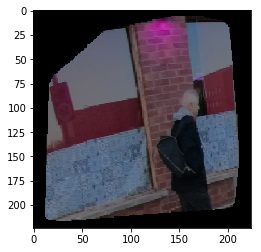

0 ./eval_5000_pixels/other/MULTISHOT_0414_000434_1masked.png


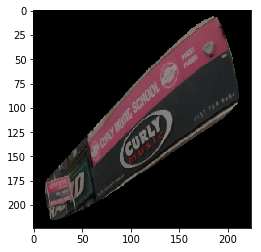

0 ./eval_5000_pixels/other/MULTISHOT_0414_004716_9masked.png


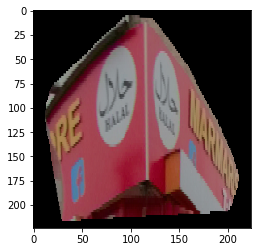

0 ./eval_5000_pixels/other/MULTISHOT_7130_004678_0masked.png


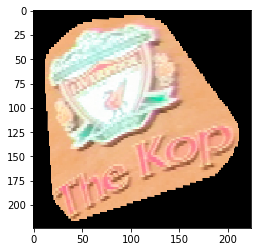

0 ./eval_5000_pixels/other/MULTISHOT_0084_005690_2masked.png


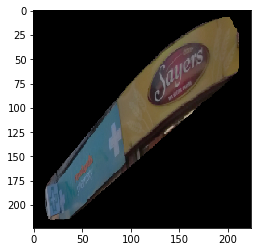

0 ./eval_5000_pixels/other/MULTISHOT_7130_007647_1masked.png


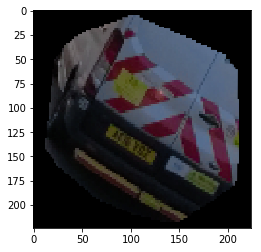

0 ./eval_5000_pixels/other/MULTISHOT_0084_005326_0masked.png


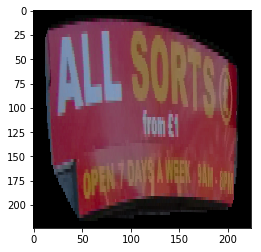

0 ./eval_5000_pixels/other/MULTISHOT_0084_001569_0masked.png


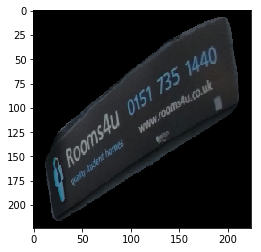

0 ./eval_5000_pixels/other/MULTISHOT_0084_000335_15masked.png


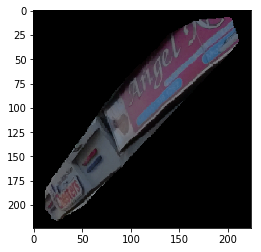

0 ./eval_5000_pixels/other/MULTISHOT_0414_004481_5masked.png


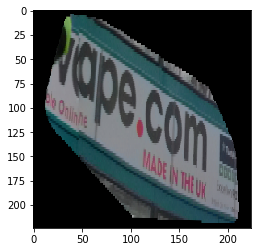

0 ./eval_5000_pixels/other/MULTISHOT_7130_006129_0masked.png


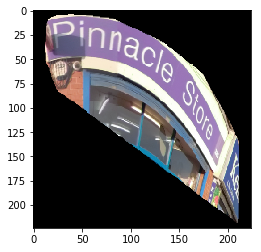

0 ./eval_5000_pixels/other/MULTISHOT_0084_005266_0masked.png


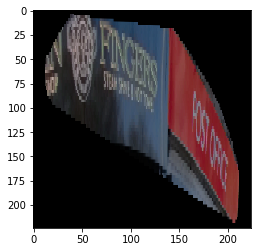

0 ./eval_5000_pixels/other/MULTISHOT_0414_002059_0masked.png


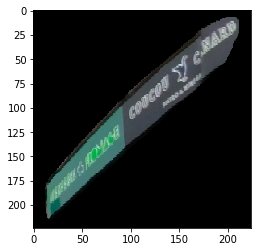

0 ./eval_5000_pixels/other/MULTISHOT_7130_006131_0masked.png


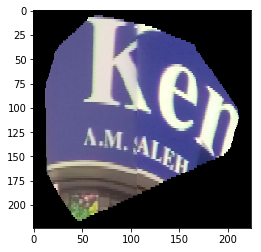

0 ./eval_5000_pixels/other/MULTISHOT_0414_000660_1masked.png


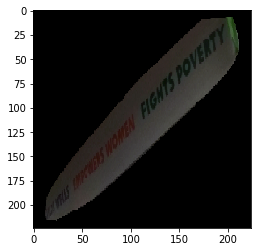

0 ./eval_5000_pixels/other/MULTISHOT_0084_000281_11masked.png


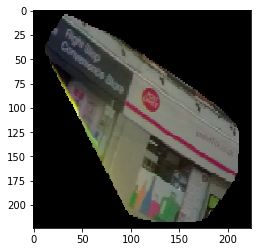

0 ./eval_5000_pixels/other/MULTISHOT_6925_000101_5masked.png


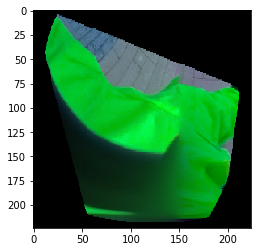

0 ./eval_5000_pixels/other/MULTISHOT_0084_000692_7masked.png


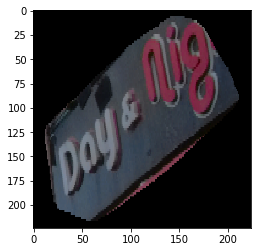

0 ./eval_5000_pixels/other/MULTISHOT_0084_005059_9masked.png


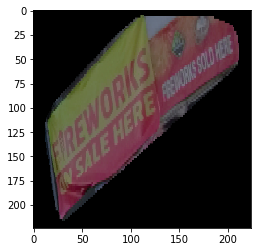

0 ./eval_5000_pixels/other/MULTISHOT_0414_000440_2masked.png


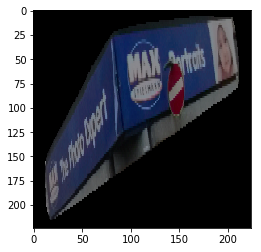

0 ./eval_5000_pixels/other/MULTISHOT_0414_002014_1masked.png


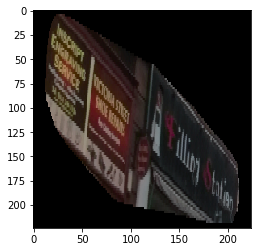

0 ./eval_5000_pixels/other/MULTISHOT_0414_004134_0masked.png


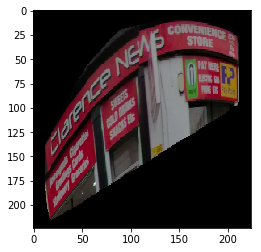

0 ./eval_5000_pixels/other/MULTISHOT_0084_001694_0masked.png


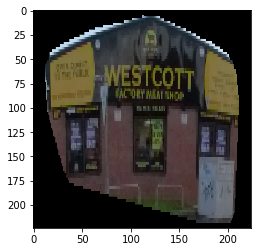

0 ./eval_5000_pixels/other/MULTISHOT_0414_000962_0masked.png


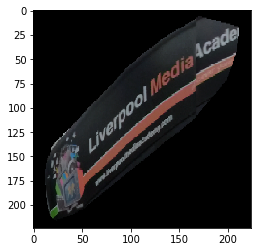

0 ./eval_5000_pixels/other/MULTISHOT_0084_000971_0masked.png


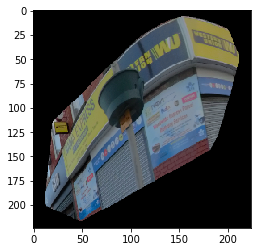

0 ./eval_5000_pixels/other/MULTISHOT_0084_000863_8masked.png


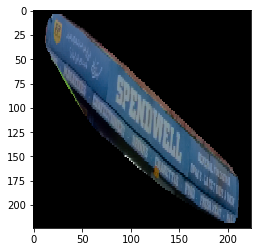

0 ./eval_5000_pixels/other/MULTISHOT_0414_000432_1masked.png


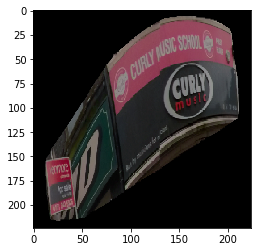

0 ./eval_5000_pixels/other/MULTISHOT_0084_000658_1masked.png


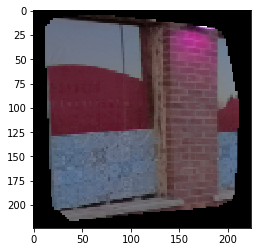

0 ./eval_5000_pixels/other/MULTISHOT_0414_003175_0masked.png


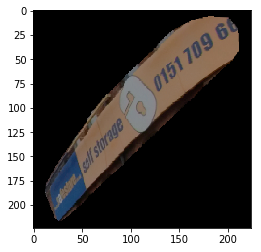

0 ./eval_5000_pixels/other/MULTISHOT_7130_002986_0masked.png


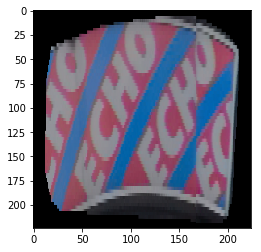

0 ./eval_5000_pixels/other/MULTISHOT_0084_000660_2masked.png


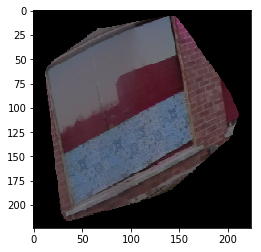

In [ ]:
import glob
filenames = glob.glob("./eval_5000_pixels/**/*png") #glob.glob("Results/*.png")
r = []
for filename, i in zip(filenames, range(len(filenames))):
    img = img2array(filename, (IMG_HEIGHT, IMG_WIDTH), expand=True)
    y = model.predict(img).argmax(axis=-1)
    r.append({'filename':filename, 'y':y[0]})
    if y == 0:
        print(str(y[0]) + " " + filename)
        plt.imshow(img[0], interpolation='nearest')
        plt.show()


In [ ]:
import pandas as pd
df = pd.DataFrame(r)
df.to_csv('ads_classifications.csv')

In [ ]:
df['type'] = None
df.loc[df.y == 0, 'type'] = 'Food' 
df.loc[df.y == 1, 'type'] = 'Other'
df.loc[df.y == 2, 'type'] = 'Gambling'
df.loc[df.y == 3, 'type'] = 'Alc'

In [ ]:
df.type.value_counts().plot(kind = 'bar')
plt.ylabel("Counts", fontsize=18)
plt.xlabel("Advertisement Categories", fontsize=18)

In [ ]:
for image, label in train_ds.take(1):
    #print("Image shape: ", image.numpy().shape)
    for i in range(32):
        print("Label: ", label.numpy()[i])
        plt.figure()
        plt.imshow(image.numpy()[i])
        plt.show()
    

In [ ]:
labels#, predictions